In [ ]:
from google.colab import drive
from zipfile import ZipFile
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import cv2
import glob
import tensorflow as tf
# import tensorflow_hub as hub
# from tensorflow import keras
from tensorflow.keras.models import load_model

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# extract all datasets
dogs_vs_cars_dataset = '/content/drive/MyDrive/Colab Notebooks/image-resized-cars-vs-dogs-dataset.zip'

with ZipFile(dogs_vs_cars_dataset, 'r') as zip:
  zip.extractall()
  print('The cars and dogs dataset is extracted')

The cars and dogs dataset is extracted


In [ ]:
# Creating labels for resized images of cars and dogs
# Car --> 0
# Dog --> 1

# creaing a for loop to assign labels
filenames = os.listdir('/content/image-resized-cars-vs-dogs-dataset/')

labels = []

for i in range(len(filenames)):

  file_name = filenames[i]
  label = file_name[0:3]

  if label == 'dog':
    labels.append(1)

  else:
    labels.append(0)

In [ ]:
image_extension = ['png', 'jpg']

files = []

[files.extend(glob.glob('/content/image-resized-cars-vs-dogs-dataset/*.' + e)) for e in image_extension]

cars_vs_dogs_images = np.asarray([cv2.imread(file) for file in files])

In [ ]:
model = tf.keras.models.load_model(
       ('/content/drive/MyDrive/Colab Notebooks/MobileNetModel/model.h5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

In [ ]:
def predict_image(img_path):

  input_image = cv2.imread(img_path)

  cv2_imshow(input_image)

  input_image_resize = cv2.resize(input_image, (224,224))

  input_image_scaled = input_image_resize/255

  image_reshaped = np.reshape(input_image_scaled, [1,224,224,3])

  input_prediction = model.predict(image_reshaped)

  print(input_prediction)

  input_pred_label = np.argmax(input_prediction)

  print(input_pred_label)

  if input_pred_label == 0:
    print('The image represents a Car')

  else:
    print('The image represents a Dog')

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.3 MB/s eta 0:00:00


In [ ]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
def f(X):
    tmp = X.copy()
    tmp = tmp/255
    return model(tmp)

In [ ]:
def shap_explainer(img_path):

  input_image = cv2.imread(img_path)

  input_image_resize = cv2.resize(input_image, (224,224))

  image_reshaped = np.reshape(input_image_resize, [1,224,224,3])


  class_names=['car', 'dog']
  # define a masker that is used to mask out partitions of the input image, this one uses a blurred background
  masker = shap.maskers.Image("inpaint_telea", (224, 224, 3))


  # By default the Partition explainer is used for all  partition explainer
  explainer = shap.Explainer(f, masker, output_names=class_names)

  # here we use 500 evaluations of the underlying model to estimate the SHAP values
  shap_values = explainer(image_reshaped, max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])
  critical_pixels_boolean = shap_values.values[0][:, :, :, 0]*10000 > 1
  critical_pixels_boolean = critical_pixels_boolean.astype(int)
  critical_pixels = input_image_resize * critical_pixels_boolean
  return critical_pixels

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:55, 55.29s/it]               


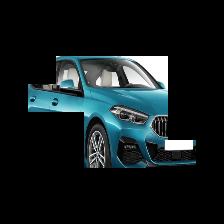

In [ ]:
shap_values = shap_explainer('/content/car.jpg')
cv2_imshow(shap_values)

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=138dc69f2a4f41cf4ef64fc2718c7703852d7547912c252afcd247053c0935e6
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def lime_explainer(img_path):
  explainer = lime_image.LimeImageExplainer()

  input_image = cv2.imread(img_path)

  input_image_resize = cv2.resize(input_image, (224,224))

  image_reshaped = np.reshape(input_image_resize, [1,224,224,3])

  explanation = explainer.explain_instance((input_image_resize/255).astype('double'), model.predict, top_labels=1, hide_color=0, num_samples=500)

  temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
  # plt.imshow(mark_boundaries(temp_1, mask_1))
  return temp_1*255


In [ ]:
lime_values = lime_explainer('/content/car.jpg')

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 1s 758ms/step


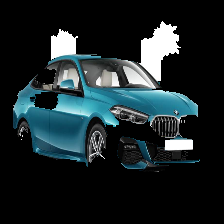

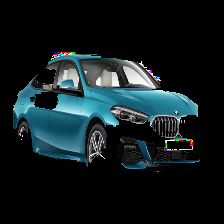

In [ ]:
cv2_imshow(lime_values)
test1 = lime_values > 0
test2 = lime_values < 255
test = test1*test2
test = test.astype(int)
# test =  test1*test2
cv2_imshow(lime_values*test)

In [ ]:
def combine_shap_n_lime(img_path):

  input_image = cv2.imread(img_path)

  input_image_resize = cv2.resize(input_image, (224,224))

  shap_arr = shap_explainer(img_path)
  lime_arr = lime_explainer(img_path)
  test = shap_arr > 0
  test2 = test.astype(int)
  test3 = lime_arr*test2

  test4 = shap_arr != lime_arr
  test4 = test4.astype(int)
  # print(test4)
  cv2_imshow(test3)
  cv2_imshow(input_image_resize*test4)

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:37, 37.59s/it]               


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 305ms/step


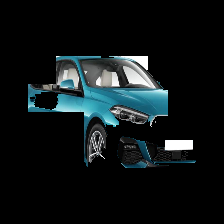

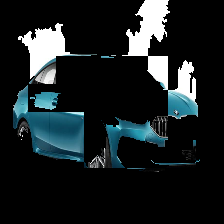

In [ ]:
combine_shap_n_lime('/content/car.jpg')